# Email Classification Data Preperation Pipeline
![alt text](.\data_collection.png)

#### In this pipeline, there are two source of emails:
1. Enron Email collection, which is downloaded from https://www.cs.cmu.edu/~./enron/
2. Synthetic Data Collection, which is manually extracted from Chat GPT

#### There are three classes, which are implemented for email extraction: 
1. EnronEmailExtraction : this class supports extracting emails from enron email dataset.
2. SytheticEmailExtraction: this class supports extracting emails from synthetic email dataset.
3. EmailClassificationExtraction: this class wraps the both extraction process to simplify the code.

In [305]:
import os
import email
import csv
from datetime import datetime
import pandas as pd
import numpy as np
import warnings
from sklearn.exceptions import ConvergenceWarning
# Filter out ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [306]:
# extracting all enron emails is time-consuming
# for demontration switch this flag to True
demo = True
class EnronEmailExtraction:
    def __init__(self, path):
        self.path = path
        self.email_list = []
        self.data_list = []
        self.mapping = {'resumes': 'HR', 'logistics': 'Shipping', 'tw-commercial group': 'Business', 'online trading': 'Sale'}
    
    def load_email_list(self):
        if os.path.exists(self.path):
            for name in os.listdir(self.path):
                person_folder = os.path.join(self.path, name)
                for folder in os.listdir(person_folder):
                    email_folder = os.path.join(person_folder, folder)
                    if os.path.isdir(person_folder) and os.path.exists(email_folder) and os.path.isdir(email_folder):
                        for name in os.listdir(email_folder):
                            file_path = os.path.join(email_folder, name)
                            if os.path.isfile(file_path):
                                self.email_list.append(file_path)

    def extract_fields(self, mail_content, headers):
        data = []
        msg = email.message_from_string(mail_content)
        for header in headers:
            try:
                folder = msg['X-Folder']
                folder = folder.split("\\")[-1].lower()
                if folder in self.mapping:
                    if header == 'Body':
                        data.append(msg.get_payload(decode=True).decode().replace('\t',' ').replace('\n', ' '))
                    elif header == 'Targets':
                        data.append(self.mapping[folder])
                    elif msg[header]:
                        data.append(msg[header].replace('\n', ' ').replace('\t', ' '))
                    else:
                        data.append(' ')
            except Exception as e:
                pass

        return data

    @staticmethod
    def read_mail(mail_path):
        data = ''
        with open(mail_path, 'r') as f:
            data = f.read()
        return data

    def extract_emails(self, headers = ['From', 'To','Subject', 'Date', 'X-Folder', 'Body', 'Targets']):   
        self.load_email_list()
        start, end = (0, len(self.email_list))
        
        if demo:
            end = 10
            
        for mail_path in self.email_list[start: end]:
            print("Reading {}".format(mail_path))
            data = EnronEmailExtraction.read_mail(mail_path)
            self.data_list.append(self.extract_fields(data, headers))
    
    # csv_file: exported file name
    # headers: a list of headers of the csv file
    # headers_format: dict {header: format_pattern} of the header columns
    def export_to_csv(self, csv_file_path, headers = ['From', 'To','Subject', 'Date', 'X-Folder', 'Body', 'Targets']):
        with open(csv_file_path, 'w', newline='', encoding='utf-8') as f:
            csv_writer = csv.writer(f, delimiter='\t')
            csv_writer.writerow(headers)
            for row in self.data_list:
                csv_writer.writerow(row)
    
    def convert_to_dataframe(self, headers = ['From', 'To','Subject', 'Date', 'X-Folder', 'Body', 'Targets']):
        if demo:
            return pd.read_csv('mails.csv', delimiter='\t')     
        else:
            return pd.DataFrame(self.data_list, columns = headers)

In [307]:
class SytheticEmailExtraction:
    def __init__(self, path, target):
        self.path = path
        self.data_list = []
        self.target = target

    @staticmethod
    def read_text(path):
        data = ''
        with open(path, 'r') as f:
            data = f.read()
        return data

    def extract_emails(self):
        if os.path.exists(self.path):
            emails = SytheticEmailExtraction.read_text(self.path)
            emails_arr = emails.split("---")

            rows = []
            for email in emails_arr:
                row = []
                if email.strip():
                    split_data = email.strip().replace('\n\n','\n').strip().split('\n')
                    subject = split_data[0].split(":")[1].strip()
                    body = split_data[2:-2]
                    row.append(subject)
                    row.append(" ".join(body).replace('\t',' ').replace('\n', ' '))
                    row.append(self.target)
                    self.data_list.append(row)

    def export_to_csv(self, csv_file_path, headers=['Subject', 'Body', 'Targets']):
        with open(csv_file_path, 'w', newline='', encoding='utf-8') as f:
            csv_writer = csv.writer(f)
            csv_writer.writerow(headers)
            for row in self.data_list:
                csv_writer.writerow(row)
                
    def convert_to_dataframe(self, headers=['Subject', 'Body', 'Targets']):
        return pd.DataFrame(self.data_list, columns=headers)

In [308]:
class EmailClassificationExtraction:
    def __init__(self, emails):
        self.emails = {}
        for key in emails:
            self.add_emails(emails[key], key)
    
    def add_emails(self, path, target):
        if target.lower() == 'enron':
            self.emails[target.lower()] = EnronEmailExtraction(path)
        else:
            self.emails[target.lower()] = SytheticEmailExtraction(path, target)  
            
    def extract_emails(self):
        for email in self.emails.values():
            email.extract_emails()
            
    def to_dataframe(self):
        return pd.concat([email.convert_to_dataframe() for email in self.emails.values()], axis=0)

# 1. Data Collection

In [309]:
# defining a mapping email type -> email source 
emails = {
    'enron': os.path.join('.', 'enron_mail_20150507', 'maildir'),
    'finance': os.path.join('.', 'Finance_email.txt'),
    'it': os.path.join('.', 'IT_email.txt')
}

email_extraction = EmailClassificationExtraction(emails)

In [310]:
# Extracting emails from source files and convert them to a dataframe
email_extraction.extract_emails()
df = email_extraction.to_dataframe()

Reading .\enron_mail_20150507\maildir\allen-p\all_documents\1
Reading .\enron_mail_20150507\maildir\allen-p\all_documents\10
Reading .\enron_mail_20150507\maildir\allen-p\all_documents\100
Reading .\enron_mail_20150507\maildir\allen-p\all_documents\101
Reading .\enron_mail_20150507\maildir\allen-p\all_documents\102
Reading .\enron_mail_20150507\maildir\allen-p\all_documents\103
Reading .\enron_mail_20150507\maildir\allen-p\all_documents\104
Reading .\enron_mail_20150507\maildir\allen-p\all_documents\105
Reading .\enron_mail_20150507\maildir\allen-p\all_documents\106
Reading .\enron_mail_20150507\maildir\allen-p\all_documents\107


# 2. Data Exploration

In [311]:
print('Checking to see if the targets is imbalance or not:')
print('---------------------------------------------------')
print(df['Targets'].value_counts())
print('---------------------------------------------------')

Checking to see if the targets is imbalance or not:
---------------------------------------------------
Targets
Shipping    1192
Business    1159
it           760
HR           606
finance      593
Sale         573
Name: count, dtype: int64
---------------------------------------------------


In [312]:
# Checking the dataset information
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4883 entries, 0 to 759
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   From      3530 non-null   object
 1   To        3530 non-null   object
 2   Subject   4883 non-null   object
 3   Date      3530 non-null   object
 4   X-Folder  3530 non-null   object
 5   Body      4883 non-null   object
 6   Targets   4883 non-null   object
dtypes: object(7)
memory usage: 305.2+ KB


In [313]:
# Selecting useful features from dataset
selected_df = df[['Subject', 'Body', 'Targets']].copy()

In [314]:
selected_df

,Subject,Body,Targets
0,Opportunities,"Sally, Thanks for taking the time to meet wit...",HR
1,Resume - Jasmine Master Katrak,Toni - Sally suggested I forward this resume ...,HR
2,Resume for Margaret Dhont,"Sally, As discussed, attached below is the re...",HR
3,Re: Associates PRC Meeting,Here's my resume for your review. Grant W. ...,HR
4,Mid year review - resume,"Sally, Per your request, here is a copy of my...",HR
...,...,...,...
755,Urgent,I hope you're doing well. We're facing an urge...,it
756,Error Message,I hope you're doing well. We're encountering a...,it
757,Issue with Access Database,I trust you're having a good day. We're facing...,it
758,Issue with Access Database,I hope this email finds you well. We're encoun...,it


In [315]:
selected_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4883 entries, 0 to 759
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Subject  4883 non-null   object
 1   Body     4883 non-null   object
 2   Targets  4883 non-null   object
dtypes: object(3)
memory usage: 152.6+ KB


In [316]:
print('Checking to see if there are any NaN values in the dataset.')
print('-----------------------------------------------------------')
print(selected_df.isna().sum())
print('-----------------------------------------------------------')

Checking to see if there are any NaN values in the dataset.
-----------------------------------------------------------
Subject    0
Body       0
Targets    0
dtype: int64
-----------------------------------------------------------


#### Helper functions
Below are untility functions which helps data mining steps cleaner and easier to re-use.

In [317]:
import nltk
#nltk.download('stopwords')
#nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import cross_validate
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from imblearn.over_sampling import SMOTE
import time
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.naive_bayes import MultinomialNB
import seaborn as sns

metrics = []

def hyperparameters_tuning(model, X, y, X_test, y_test, param_grid, cv=10):
    # Initialize GridSearchCV
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv, scoring='accuracy')

    # Perform grid search
    grid_search.fit(X, y)

    # Print the best hyperparameters found
    print("Best hyperparameters:", grid_search.best_params_)

    # Evaluate the best model on the test set
    best_model = grid_search.best_estimator_
    train_accuracy = best_model.score(X_res, y_res)
    test_accuracy = best_model.score(X_test, y_test)
    # Create confusion matrix
    y_pred = best_model.predict(X_test)
    conf_matrix = confusion_matrix(y_test, y_pred)
    print('-------------------------------------------------------------------------------------------------------------')
    print("Train accuracy:", train_accuracy)
    print("Test accuracy:", test_accuracy)
    print('-------------------------------------------------------------------------------------------------------------')
    # Print classification report
    print(classification_report(y_test, y_pred, target_names=encoder.classes_))
    print('-------------------------------------------------------------------------------------------------------------')
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()
    
    return train_accuracy, test_accuracy, grid_search.best_params_, 

def unique_words_count(text):
    words = text.split()
    return len(set(words))

def summarize_emails(data_df):
    total_document_length = data_df['Subject_Body'].apply(lambda text: len(text)).sum()
    total_document = data_df.shape[0]
    unique_words = data_df['Subject_Body'].apply(unique_words_count).sum()
                                                   
    print('Total Documents: ', total_document)
    print('Document Length: {} words'.format(total_document_length))
    print('Average Document Length: {} words'.format(total_document_length/total_document))
    print('Vocabulary Size: {} unique words'.format(unique_words))
    
def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(text)
    filtered_text = [word for word in word_tokens if word not in stop_words]
    return ' '.join(filtered_text)

def remove_punctuation(text):
    tokens = word_tokenize(text)
    tokens_without_punctuation = [token for token in tokens if token.isalnum()]
    return ' '.join(tokens_without_punctuation)

def remove_stopwords_and_punctuation(text):
    return remove_stopwords(remove_punctuation(text))

def perform_cross_validation_and_report(model, X, y, cv=10):
    start = time.time()
    scoring = {
            'acc': 'accuracy',
            'f1_mac': 'f1_macro',
            'jacc_mac': 'jaccard_macro'
    }
    scores = cross_validate(model, X, y, cv=cv, scoring=scoring)
    training_time = (time.time() - start)
    print("accuracy: ", scores['test_acc'].mean())
    print("f1_score: ", scores['test_f1_mac'].mean())
    print("Jaccard_index: ", scores['test_jacc_mac'].mean())
    print("time (sec): ", training_time) 

def perform_learning_curve_and_visualization(model, X, y, cv=10, title='Learning Curve'):
    # Define the number of training examples to plot learning curve
    train_sizes = np.linspace(0.1, 1.0, 10)  # Use 10 different training sizes

    # Generate learning curve data
    train_sizes, train_scores, valid_scores = learning_curve(model, X, y, train_sizes=train_sizes, cv=cv)

    # Calculate mean and standard deviation of training and validation scores
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    valid_mean = np.mean(valid_scores, axis=1)
    valid_std = np.std(valid_scores, axis=1)

    # Plot learning curve
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, label='Training score', color='blue')
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='blue', alpha=0.1)
    plt.plot(train_sizes, valid_mean, label='Cross-validation score', color='orange')
    plt.fill_between(train_sizes, valid_mean - valid_std, valid_mean + valid_std, color='orange', alpha=0.1)
    plt.title(title)
    plt.xlabel('Number of training examples')
    plt.ylabel('Score')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

# 3. Feature Engineering

In [318]:
# Combining email subject and email body together
selected_df['Subject_Body'] = selected_df['Subject'] + ' ' + selected_df['Body']

In [319]:
selected_df

,Subject,Body,Targets,Subject_Body
0,Opportunities,"Sally, Thanks for taking the time to meet wit...",HR,"Opportunities Sally, Thanks for taking the ti..."
1,Resume - Jasmine Master Katrak,Toni - Sally suggested I forward this resume ...,HR,Resume - Jasmine Master Katrak Toni - Sally s...
2,Resume for Margaret Dhont,"Sally, As discussed, attached below is the re...",HR,"Resume for Margaret Dhont Sally, As discussed..."
3,Re: Associates PRC Meeting,Here's my resume for your review. Grant W. ...,HR,Re: Associates PRC Meeting Here's my resume fo...
4,Mid year review - resume,"Sally, Per your request, here is a copy of my...",HR,"Mid year review - resume Sally, Per your requ..."
...,...,...,...,...
755,Urgent,I hope you're doing well. We're facing an urge...,it,Urgent I hope you're doing well. We're facing ...
756,Error Message,I hope you're doing well. We're encountering a...,it,Error Message I hope you're doing well. We're ...
757,Issue with Access Database,I trust you're having a good day. We're facing...,it,Issue with Access Database I trust you're havi...
758,Issue with Access Database,I hope this email finds you well. We're encoun...,it,Issue with Access Database I hope this email f...


In [320]:
print('Summary Information before removing stopwords and punctuations:')
print('---------------------------------------------------------------')
summarize_emails(selected_df)
print('---------------------------------------------------------------')

Summary Information before removing stopwords and punctuations:
---------------------------------------------------------------
Total Documents:  4883
Document Length: 4549997 words
Average Document Length: 931.8036043415933 words
Vocabulary Size: 444097 unique words
---------------------------------------------------------------


In [321]:
# lowercase all email content before filtering stopwords, punctuations
selected_df['Subject_Body'] = selected_df['Subject_Body'].str.lower()
selected_df['Targets'] = selected_df['Targets'].str.lower()
# filter stopwords and punctuations
selected_df['Subject_Body'] = selected_df['Subject_Body'].apply(remove_stopwords_and_punctuation)

In [322]:
print('Summary Information after removing stopwords and punctuations:')
print('---------------------------------------------------------------')
summarize_emails(selected_df)
print('---------------------------------------------------------------')

Summary Information after removing stopwords and punctuations:
---------------------------------------------------------------
Total Documents:  4883
Document Length: 2709638 words
Average Document Length: 554.9125537579357 words
Vocabulary Size: 258439 unique words
---------------------------------------------------------------


In [323]:
selected_df

,Subject,Body,Targets,Subject_Body
0,Opportunities,"Sally, Thanks for taking the time to meet wit...",hr,opportunities sally thanks taking time meet to...
1,Resume - Jasmine Master Katrak,Toni - Sally suggested I forward this resume ...,hr,resume jasmine master katrak toni sally sugges...
2,Resume for Margaret Dhont,"Sally, As discussed, attached below is the re...",hr,resume margaret dhont sally discussed attached...
3,Re: Associates PRC Meeting,Here's my resume for your review. Grant W. ...,hr,associates prc meeting resume review grant zim...
4,Mid year review - resume,"Sally, Per your request, here is a copy of my...",hr,mid year review resume sally per request copy ...
...,...,...,...,...
755,Urgent,I hope you're doing well. We're facing an urge...,it,urgent hope well facing urgent issue indexing ...
756,Error Message,I hope you're doing well. We're encountering a...,it,error message hope well encountering error mes...
757,Issue with Access Database,I trust you're having a good day. We're facing...,it,issue access database trust good day facing ch...
758,Issue with Access Database,I hope this email finds you well. We're encoun...,it,issue access database hope email finds well en...


In [324]:
# Initialize the LabelEncoder
encoder = LabelEncoder()
# Numerize the labels
selected_df['Target_Encode'] = encoder.fit_transform(selected_df['Targets'])

In [325]:
encoder.classes_

array(['business', 'finance', 'hr', 'it', 'sale', 'shipping'],
      dtype=object)

In [326]:
# shuffling data helps to improve the performance, fairness, and robustness 
# ensuring randomness and reducing biases in the dataset.
selected_df = selected_df.sample(frac=1, random_state=42)

In [327]:
# selected the features for building the model
data_df = selected_df.drop(['Subject', 'Body', 'Targets'], axis=1)

In [328]:
data_df

,Subject_Body,Target_Encode
1149,pg e texoma volumes reviewing imbalance number...,5
393,duke energy duke paid may 2000 july august 200...,5
1268,backup please note backup changed effective im...,4
108,cooling system fan failure regret inform diagn...,3
1786,greeting charles dear molly happy new year tal...,2
...,...,...
303,microsoft word unable save error appears error...,3
466,weekend gas wanted review weekend sales southe...,5
3092,january 22nd update jeff michelle ken attached...,0
242,question monitor compatibility existing comput...,1


In [329]:
print('Checking to see if labels are imbalance or not:')
print('-----------------------------------------------')
print(data_df[['Target_Encode']].value_counts())
print('-----------------------------------------------')

Checking to see if labels are imbalance or not:
-----------------------------------------------
Target_Encode
5                1192
0                1159
3                 760
2                 606
1                 593
4                 573
Name: count, dtype: int64
-----------------------------------------------


In [330]:
# spliting dataset into training and testing
train_data, test_data = train_test_split(data_df[['Subject_Body', 'Target_Encode']], random_state=100)

#### Applying Bag-of-words to training and testing dataset

In [331]:
# Initialize the CountVectorizer
bow_transform = CountVectorizer()
# numerize training dataset
X_train_bow = bow_transform.fit_transform(train_data['Subject_Body'])
# numerize testing dataset
X_test_bow = bow_transform.transform(test_data['Subject_Body'])

# 4. Data Transformation

In [332]:
# Because the labels are imbalance, applying over-sampling to make them balance
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train_bow, train_data['Target_Encode'])

In [333]:
print('Re-check the over-samplaing data:')
print('---------------------------------')
print(y_res.value_counts())
print('---------------------------------')

Re-check the over-samplaing data:
---------------------------------
Target_Encode
4    890
1    890
5    890
0    890
2    890
3    890
Name: count, dtype: int64
---------------------------------


In [334]:
X_res.shape

(5340, 15975)

# 5. Cross validation and model selection

#### MultinomialNB algorithm with Bag-of-Words

In [335]:
# Initialize the MultinomialNB classifier
model = MultinomialNB()
# perform cross validation
print('Bag-of-Words MultinomialNB Cross Validation Report:')
print('-----------------------------------------------------')
perform_cross_validation_and_report(model, X_res, y_res, cv=5)
print('-----------------------------------------------------')

Bag-of-Words MultinomialNB Cross Validation Report:
-----------------------------------------------------
accuracy:  0.9683520599250937
f1_score:  0.9683342435084435
Jaccard_index:  0.939709386710484
time (sec):  0.13824748992919922
-----------------------------------------------------


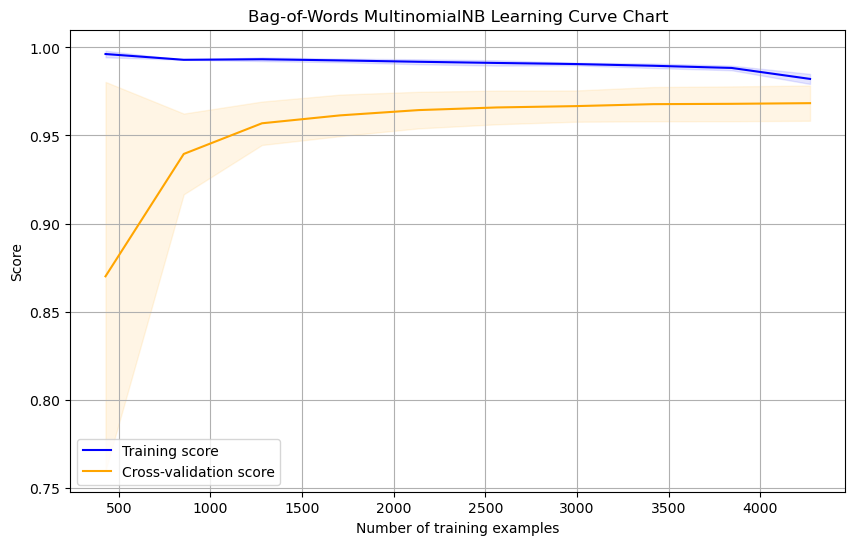

In [336]:
# Initialize MultinomialNB classifier
model = MultinomialNB()
# perform learning curve and visualization
perform_learning_curve_and_visualization(model, X_res, y_res, cv=5, title='Bag-of-Words MultinomialNB Learning Curve Chart')

Bag-of-words MultinomialNB hyperparameters_tuning Report:
***************************************************************************************************
Best hyperparameters: {'alpha': 0.1, 'fit_prior': True}
-------------------------------------------------------------------------------------------------------------
Train accuracy: 0.9855805243445693
Test accuracy: 0.9778869778869779
-------------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

    business       0.95      0.99      0.97       287
     finance       1.00      1.00      1.00       159
          hr       0.97      0.98      0.97       144
          it       1.00      1.00      1.00       183
        sale       0.97      0.97      0.97       146
    shipping       0.99      0.95      0.97       302

    accuracy                           0.98      1221
   macro avg       0.98      0.98      0.98      1221
weighted 

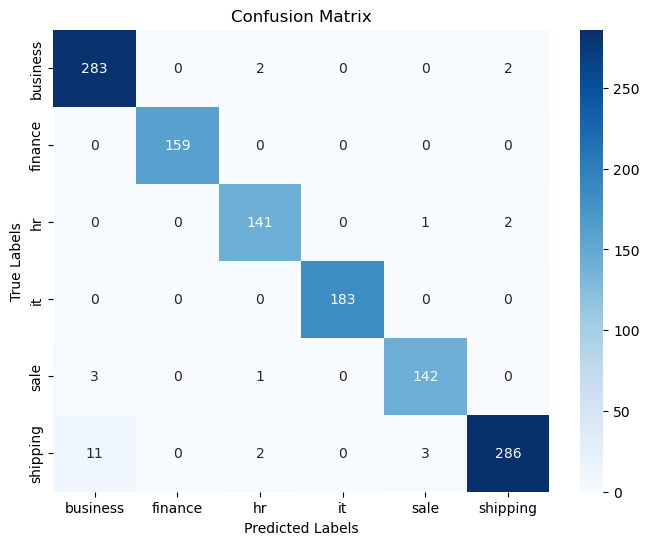

In [337]:
# Initialize MultinomialNB classifier
model = MultinomialNB()

# Define hyperparameters grid to search
param_grid = {
    'alpha': [0.1, 0.5, 1.0, 2.0],
    'fit_prior': [True, False]
}

print('Bag-of-words MultinomialNB hyperparameters_tuning Report:')
print('***************************************************************************************************')
train_accuracy, test_accuracy, best_param = hyperparameters_tuning(model, X_res, y_res, X_test_bow, test_data['Target_Encode'], param_grid, cv=5)
metrics.append([train_accuracy, test_accuracy])

#### LinearSVC algorithm with Bag-of-Words

In [338]:
# Initialize the LinearSVC model
model =  LinearSVC(dual='auto')
# perform cross valodation
print('Bag-of-Words LinearSVC Cross Validation Report')
print('-----------------------------------------------------')
perform_cross_validation_and_report(model, X_res, y_res, cv=5)
print('-----------------------------------------------------')

Bag-of-Words LinearSVC Cross Validation Report
-----------------------------------------------------
accuracy:  0.9574906367041199
f1_score:  0.9572896276747113
Jaccard_index:  0.9201244009521607
time (sec):  3.300747871398926
-----------------------------------------------------


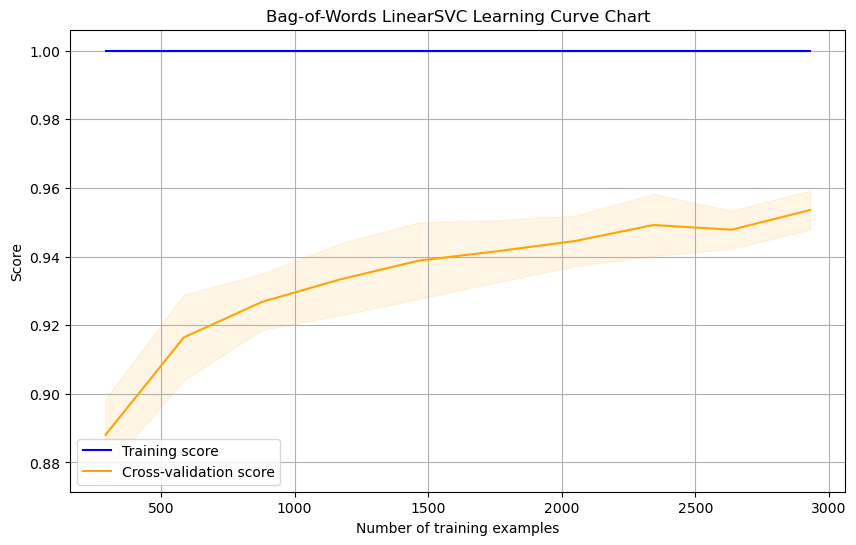

In [339]:
# Initialize LinearSVC classifier
model = LinearSVC(dual='auto')
# perform learning curve and visualize it
perform_learning_curve_and_visualization(model, X_train_bow, train_data['Target_Encode'], cv=5, title='Bag-of-Words LinearSVC Learning Curve Chart')

Bag-of-words LinearSVC hyperparameters_tuning Report:
***************************************************************************************************
Best hyperparameters: {'C': 0.01, 'penalty': 'l2'}
-------------------------------------------------------------------------------------------------------------
Train accuracy: 0.9913857677902622
Test accuracy: 0.9647829647829648
-------------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

    business       0.96      0.96      0.96       287
     finance       0.99      1.00      1.00       159
          hr       0.96      0.99      0.97       144
          it       0.98      1.00      0.99       183
        sale       0.88      0.97      0.93       146
    shipping       0.99      0.91      0.95       302

    accuracy                           0.96      1221
   macro avg       0.96      0.97      0.97      1221
weighted avg      

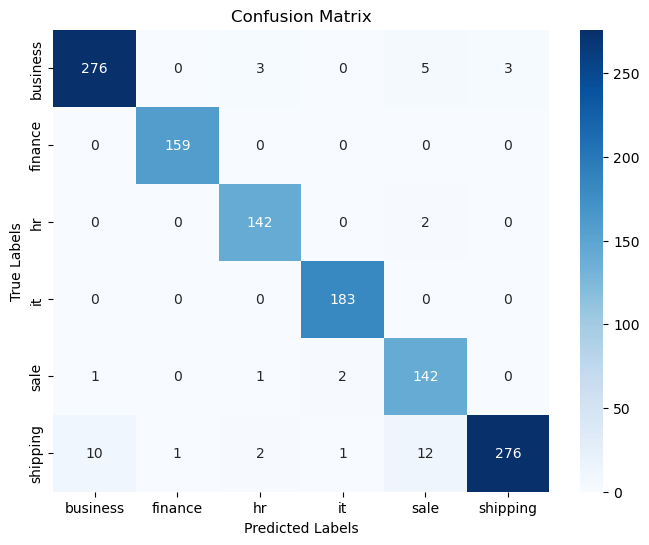

In [340]:
# Initialize MLPClassifier classifier
svc = LinearSVC(dual='auto')

# Define hyperparameters grid to search
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
}

print('Bag-of-words LinearSVC hyperparameters_tuning Report:')
print('***************************************************************************************************')
train_accuracy, test_accuracy, best_param = hyperparameters_tuning(svc, X_res, y_res, X_test_bow, test_data['Target_Encode'], param_grid, cv=5)
metrics.append([train_accuracy, test_accuracy])

#### Applying Term Frequency - Inverse Document Frequency (TF-IDF) to train and test dataset

In [341]:
# Initialize the TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()
# numerize train dataset
X_train_tfidf = tfidf_vectorizer.fit_transform(train_data['Subject_Body'])
# numerize test dataset
X_test_tfidf = bow_transform.transform(test_data['Subject_Body'])


In [342]:
# Because the labels are imbalance, applying over-sampling to make them balance
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train_tfidf, train_data['Target_Encode'])

#### Multinomial with TF-IDF

In [343]:
# Initialize the MultinomialNB
model = MultinomialNB()
print('Multinomial with TF-IDF Cross Validation Report:')
print('-----------------------------------------------------')
perform_cross_validation_and_report(model, X_res, y_res, cv=5)
print('-----------------------------------------------------')

Multinomial with TF-IDF Cross Validation Report:
-----------------------------------------------------
accuracy:  0.9752808988764045
f1_score:  0.9751563607218324
Jaccard_index:  0.9522844487604185
time (sec):  0.15569305419921875
-----------------------------------------------------


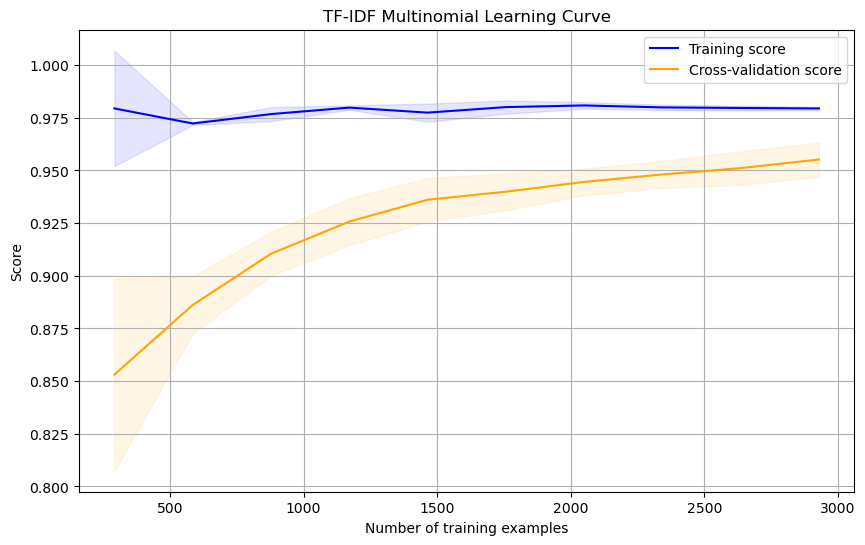

In [344]:
# Initialize MultinomialNB classifier
model = MultinomialNB()

perform_learning_curve_and_visualization(model, X_train_tfidf, train_data['Target_Encode'], cv=5, title='TF-IDF Multinomial Learning Curve')

TF-IDF MultinomialNB hyperparameters_tuning Report:
***************************************************************************************************
Best hyperparameters: {'alpha': 0.1, 'fit_prior': True}
-------------------------------------------------------------------------------------------------------------
Train accuracy: 0.9956928838951311
Test accuracy: 0.9746109746109746
-------------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

    business       0.96      0.98      0.97       287
     finance       1.00      1.00      1.00       159
          hr       0.95      0.98      0.96       144
          it       0.99      1.00      1.00       183
        sale       0.97      0.96      0.97       146
    shipping       0.98      0.94      0.96       302

    accuracy                           0.97      1221
   macro avg       0.98      0.98      0.98      1221
weighted avg   

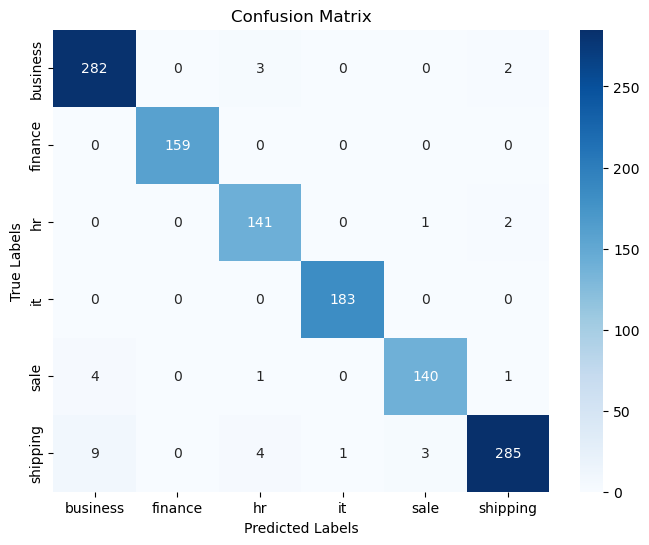

In [345]:
# Initialize MultinomialNB classifier
model = MultinomialNB()

# Define hyperparameters grid to search
param_grid = {
    'alpha': [0.1, 0.5, 1.0, 2.0],
    'fit_prior': [True, False]
}

print('TF-IDF MultinomialNB hyperparameters_tuning Report:')
print('***************************************************************************************************')
train_accuracy, test_accuracy, best_param = hyperparameters_tuning(model, X_res, y_res, X_test_bow, test_data['Target_Encode'], param_grid, cv=5)
metrics.append([train_accuracy, test_accuracy])

#### LinearSVC with TF-IDF

In [346]:
# Initialize the LinearSVC model
model =  LinearSVC(dual='auto')

print('LinearSVC with TF-IDF Cross Validation Report')
print('-----------------------------------------------------')
perform_cross_validation_and_report(model, X_res, y_res, cv=5)
print('-----------------------------------------------------')

LinearSVC with TF-IDF Cross Validation Report
-----------------------------------------------------
accuracy:  0.9835205992509364
f1_score:  0.9835081284478882
Jaccard_index:  0.9680999494327296
time (sec):  1.0747849941253662
-----------------------------------------------------


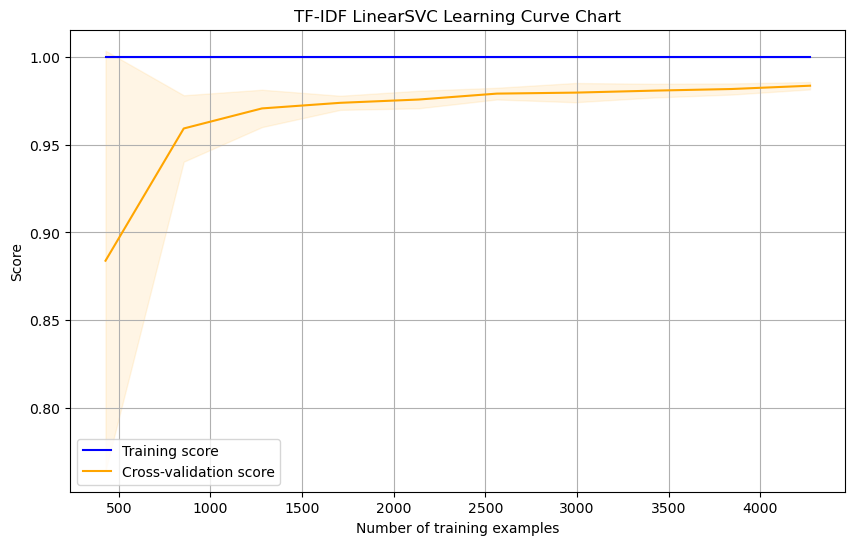

In [347]:
# Initialize MultinomialNB classifier
model = LinearSVC(dual='auto')

perform_learning_curve_and_visualization(model, X_res, y_res, cv=5, title='TF-IDF LinearSVC Learning Curve Chart')

TF-IDF LinearSVC hyperparameters_tuning Report:
***************************************************************************************************
Best hyperparameters: {'C': 10, 'penalty': 'l2'}
-------------------------------------------------------------------------------------------------------------
Train accuracy: 1.0
Test accuracy: 0.9680589680589681
-------------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

    business       0.95      0.97      0.96       287
     finance       0.97      1.00      0.98       159
          hr       0.97      0.99      0.98       144
          it       0.99      1.00      0.99       183
        sale       0.96      0.99      0.97       146
    shipping       0.98      0.91      0.94       302

    accuracy                           0.97      1221
   macro avg       0.97      0.98      0.97      1221
weighted avg       0.97      0.97      0.

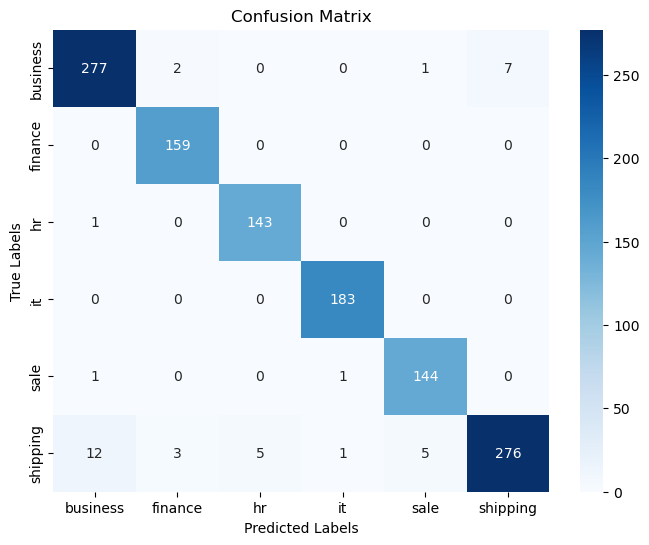

In [348]:
# Initialize MultinomialNB classifier
model = LinearSVC(dual='auto')

# Define hyperparameters grid to search
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
}

print('TF-IDF LinearSVC hyperparameters_tuning Report:')
print('***************************************************************************************************')
train_accuracy, test_accuracy, best_param = hyperparameters_tuning(model, X_res, y_res, X_test_tfidf, test_data['Target_Encode'], param_grid, cv=5)
metrics.append([train_accuracy, test_accuracy])

In [359]:
custom_index = [('Bag-of-Word', 'MultinomialNB'),('Bag-of-Word','LinearSVC'), ('TF-IDF', 'MultinomialNB'),('TF-IDF','LinearSVC')]
multi_index = pd.MultiIndex.from_tuples(custom_index, names=['Features', 'Model'])
metrics_df = pd.DataFrame(metrics, columns=['Train Accuracy', 'Test Accuracy'], index=multi_index)
metrics_df['Total'] = metrics_df['Train Accuracy'] + metrics_df['Test Accuracy']

In [360]:
metrics_df

Train Accuracy  Test Accuracy     Total
Features    Model                                                 
Bag-of-Word MultinomialNB        0.985581       0.977887  1.963468
            LinearSVC            0.991386       0.964783  1.956169
TF-IDF      MultinomialNB        0.995693       0.974611  1.970304
            LinearSVC            1.000000       0.968059  1.968059

In [361]:
df.to_csv('enron.csv', index=False)  # Set index=False to exclude row indices from the CSV

,From,To,Subject,Date,X-Folder,Body,Targets
0,gay.mayeux@enron.com,sally.beck@enron.com,Opportunities,"Thu, 19 Apr 2001 12:01:00 -0700 (PDT)","\Beck, Sally\Beck, Sally\resumes","Sally, Thanks for taking the time to meet wit...",HR
1,gary.taylor@enron.com,"toni.graham@enron.com, sally.beck@enron.com",Resume - Jasmine Master Katrak,"Fri, 18 Aug 2000 06:05:00 -0700 (PDT)",\Sally_Beck_Dec2000\Notes Folders\Resumes,Toni - Sally suggested I forward this resume ...,HR
2,tom.may@enron.com,sally.beck@enron.com,Resume for Margaret Dhont,"Wed, 9 Aug 2000 10:06:00 -0700 (PDT)",\Sally_Beck_Dec2000\Notes Folders\Resumes,"Sally, As discussed, attached below is the re...",HR
3,grant.zimmerman@enron.com,sally.beck@enron.com,Re: Associates PRC Meeting,"Fri, 21 Jul 2000 04:12:00 -0700 (PDT)",\Sally_Beck_Dec2000\Notes Folders\Resumes,Here's my resume for your review. Grant W. ...,HR
4,shelly.friesenhahn@enron.com,sally.beck@enron.com,Mid year review - resume,"Thu, 20 Jul 2000 04:14:00 -0700 (PDT)",\Sally_Beck_Dec2000\Notes Folders\Resumes,"Sally, Per your request, here is a copy of my...",HR
...,...,...,...,...,...,...,...
755,NaN,NaN,Urgent,NaN,NaN,I hope you're doing well. We're facing an urge...,it
756,NaN,NaN,Error Message,NaN,NaN,I hope you're doing well. We're encountering a...,it
757,NaN,NaN,Issue with Access Database,NaN,NaN,I trust you're having a good day. We're facing...,it
758,NaN,NaN,Issue with Access Database,NaN,NaN,I hope this email finds you well. We're encoun...,it
